# MURA project deep learning

### Updates - 04/23/2019
1. Selected on ELBOW for training our models.
2. Models(pre-built) are now training w/o errors.
3. Need to fix issue of stagnant train acc,loss and volatile valid acc,loss by shuffling train and valid lists.

### Updates - 04/20/2019
1. Reshaping the images to be of size 512x512 which is the size used in most of the MURA implementaions on github.
2. Reshaping is done by black padding the images so that the original image stays in the center.

Dataset and competition page - https://stanfordmlgroup.github.io/competitions/mura/

In [0]:
# Import necessary libraries

# Numerical computation
import numpy as np

# Data manipulation
import pandas as pd

# Deep Learning libraries
import tensorflow as tf
from tensorflow.python import keras

# Data Viz
import matplotlib.pyplot as plt
%matplotlib inline

# Operating system lib
import os

In [0]:
# Download the MURA dataset
# Reference -
from urllib.request import urlretrieve
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip','MURA.zip')
print("All the files are downloaded")

Download file... MURA.zip ...
File downloaded
All the files are downloaded


In [0]:
# Unzip the file
!unzip MURA.zip

Archive:  MURA.zip
   creating: MURA-v1.1/
  inflating: MURA-v1.1/train_labeled_studies.csv  
  inflating: MURA-v1.1/valid_labeled_studies.csv  
  inflating: MURA-v1.1/train_image_paths.csv  
  inflating: MURA-v1.1/valid_image_paths.csv  
   creating: MURA-v1.1/valid/
   creating: MURA-v1.1/valid/XR_ELBOW/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image1.png  
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image5.png  
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image2.png  
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image3.png  
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image4.png  
   creating: MURA-v1.1/valid/XR_ELBOW/patient11860/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11860/study1_negative/
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11860/s

In [0]:
# Change working directory and display the files and folders within the MURA-v1.1 directory
os.chdir('MURA-v1.1')
os.listdir()

['train_labeled_studies.csv',
 'valid_image_paths.csv',
 'valid',
 'valid_labeled_studies.csv',
 'train',
 'train_image_paths.csv']

In [0]:
# Load the csv file as a pandas df containing the training image paths
train_image_paths = pd.read_csv('train_image_paths.csv',header=None)
train_image_paths.columns = ['image_path']
train_image_paths.head(5)

# Load the csv file as a pandas df containing the validation image paths
valid_image_paths = pd.read_csv('valid_image_paths.csv',header=None)
valid_image_paths.columns = ['image_path']
valid_image_paths.head(5)

image_path
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...

In [0]:
# Load the csv file as a pandas df containing the training study labels
train_labelled_studies = pd.read_csv('train_labeled_studies.csv',header=None)
train_labelled_studies.columns = ['study_name','label']
train_labelled_studies.head(5)

# Load the csv file as a pandas df containing the validation study labels
valid_labelled_studies = pd.read_csv('valid_labeled_studies.csv',header=None)
valid_labelled_studies.columns = ['study_name','label']
valid_labelled_studies.head(5)

study_name  label
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...      1
1  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...      1
2  MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...      1
3  MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...      1
4  MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...      1

In [0]:
# Go back one directory to the parent
os.chdir('..')

In [0]:
def addImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []

  for study_name in df['study_name']:
    image_list = [study_name+image_name for image_name in os.listdir(study_name)]
    images.append(image_list)
    
  # Add the column and return the dataframe
  df['images'] = images
  return df
  

In [0]:
# Create the new train_labelled_studies df for EDA
train_labelled_studies = addImageLists(train_labelled_studies)
# Create the new valid_labelled_studies df for EDA
valid_labelled_studies = addImageLists(valid_labelled_studies)

In [0]:
# Filter data relevant only to a particular body part
# MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/

BODY_PART = 'XR_ELBOW'

# Filter the train dataframe for a particular body part
train_labelled_studies = train_labelled_studies[train_labelled_studies['study_name'].str.contains(BODY_PART)]

# Filter the valid dataframe for a particular body part
valid_labelled_studies = valid_labelled_studies[valid_labelled_studies['study_name'].str.contains(BODY_PART)]

In [0]:
def createImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []
  labels = []
  
  for index, row in df.iterrows():
    
    study_name = row['study_name']
    label = row['label']
    
    for image_name in os.listdir(study_name):
      images.append(study_name+image_name)
      labels.append(label)
    
  return images,labels

In [0]:
# Generate the train image and label lists
train_image_list, train_label_list = createImageLists(train_labelled_studies)

# Generate the validation image and label lists
valid_image_list, valid_label_list = createImageLists(valid_labelled_studies)

In [0]:
# Shuffle train and valid lists
import sklearn
from sklearn.utils import shuffle

train_image_list, train_label_list = shuffle(train_image_list, train_label_list)

valid_image_list, valid_label_list = shuffle(valid_image_list, valid_label_list)

In [0]:
# Start an interactive tf session
sess = tf.InteractiveSession()

### Data pipeline to do list
1. Create a dataframe having the study directory, list of image paths and labels as a dataframe - DONE
2. Resize all the images to the same size.
3. Apply image augmentation techniques like : 
<p>a. Horizontal flipping<br>
b. Random rotation upto 30 degrees<br>
</p>

Important links:<br>
Pipeline creation - https://www.tensorflow.org/guide/datasets <br>
How to use this pipeline in keras models - https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27 <br>

To do for data pipeline:<br>
1. Augmentation - (30 degree rotation,horizontal flip)
2. Shuffle

To do for model:<br>
1. Test various models and note down accuracy.
2.  Create ensemble of two best models: 5 each.

To do for predictions:<br>
Function for studywise predictions.

In [0]:
# Create a tf.data pipeline using the created image and label lists.

# Set the data pipeline parameters
BATCH_SIZE = 10
SIZE = 512
CHANNELS = 3

train_filenames = tf.constant(train_image_list)
train_labels = tf.constant(train_label_list)

valid_filenames = tf.constant(valid_image_list)
valid_labels = tf.constant(valid_label_list)

def _parse_train(filename,label):
  # Read the image from disk
  image_string = tf.read_file(filename)
  # Decode the image
  image = tf.image.decode_png(image_string,channels=CHANNELS)
  # Flip the image horizontally
  image = tf.image.flip_left_right(image)
  # Rotations
  # image = tf.contrib.image.rotate(image,angles=30)
  # image = tf.contrib.image.rotate(image,angles=np.random.choice([0,10,350,20,340,30,330],size=1))
  image = tf.contrib.image.rotate(image, tf.random_uniform(shape=[1], minval=-0.5, maxval=0.5, seed=7), interpolation='BILINEAR')
  # Resize into 512x512 images
  image = tf.image.resize_image_with_crop_or_pad(image,SIZE,SIZE)
  return (image, label)

def _parse_valid(filename,label):
  # Read the image from disk
  image_string = tf.read_file(filename)
  # Decode the image
  image = tf.image.decode_png(image_string,channels=CHANNELS)
  # Resize into 512x512 images
  image = tf.image.resize_image_with_crop_or_pad(image,SIZE,SIZE)
  return (image, label)

# Train dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames,train_labels))
train_dataset = train_dataset.map(_parse_train)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=10).repeat().prefetch(1)

# Validation dataset pipeline
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_filenames,valid_labels))
valid_dataset = valid_dataset.map(_parse_valid)
valid_dataset = valid_dataset.batch(BATCH_SIZE).repeat().prefetch(1)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# Create an iterator to test our pipeline
iterator = train_dataset.make_initializable_iterator()

# Initialize the iterator
sess.run(iterator.initializer)

In [0]:
# Get a pair of an image and label
test_image, test_label = sess.run(iterator.get_next())

In [0]:
test_image.shape

(10, 512, 512, 3)

Label for the image - 0


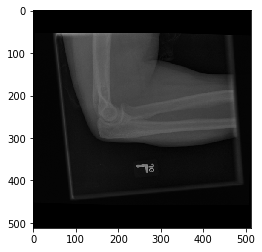

In [0]:
# Display the image
plt.imshow(test_image[3])
plt.plot()
print("Label for the image -",test_label[3])

## Trying out a VGG16 base model with pretrained ImageNet weights
To do:
1. Import the pretrained VGG16 model from Keras. - DONE
2. Change/add the last dense layer in VGG16 to finally have one 1 neuron(normal/abnormal) instead of 1000 neurons required in the ImageNet challenge. - DONE
3. Freeze the VGG16 layers to prevent large gradient update from ruining the important features. - DONE
4. Train the model - <b>Fix constant train acc/loss and very volatile valid acc/loss - DONE</b>
5. Get a baseline accuracy.  Validation accuracy on vanilla VGG16 = 76%
6. Finetune model
7. Get the finetuned accuracy.

In [0]:
#del VGG16_model

In [0]:
# Import the pretrained VGG16 model from Keras
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(SIZE,SIZE,3))

In [0]:
# Our base VGG16 model with imagenet weights
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [0]:
# Add 2 dense layers to the VGG16 model so that we get a sigmoid output
from keras import models
from keras import layers
from keras import optimizers

VGG16_model = models.Sequential()

# Freeze the original VGG16 layer weights
conv_base.trainable = False

VGG16_model.add(layers.BatchNormalization(axis=-1,center=True,scale=True,input_shape=(SIZE,SIZE,3)))
VGG16_model.add(conv_base)
VGG16_model.add(layers.pooling.GlobalAveragePooling2D())
#VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.Dense(256,activation='relu'))
VGG16_model.add(layers.Dense(1,activation='sigmoid'))

VGG16_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['acc'])

# The model summary after freezing original VGG16 weights and adding our 2 dense layers
VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,846,285
Trainable params: 131,591
Non-trainable params: 14,714,694
_________________________________________________________________


In [0]:
# Try to create a simple generator using our dataset
from keras import backend as K

def trainGenData():
  # Create an iterator to test our pipeline
  iterator = train_dataset.make_one_shot_iterator()
  # Next batch
  next_batch = iterator.get_next()
  while True:
    yield K.get_session().run(next_batch)
    
def validGenData():
  # Create an iterator to test our pipeline
  iterator = valid_dataset.make_one_shot_iterator()
  # Next batch
  next_batch = iterator.get_next()
  while True:
    yield K.get_session().run(next_batch)

trainGen = trainGenData()
validGen = validGenData()

Using TensorFlow backend.


Label 0 count = 2925
Label 1 count = 2006
Class 0 weight = 0.6858119658119658
Class 1 weight = 1.4581256231306081


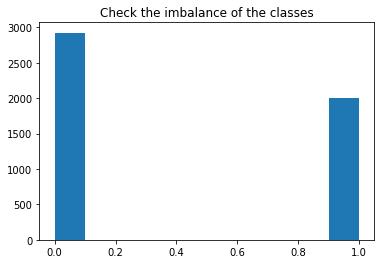

In [0]:
# Check the balance of our class labels
plt.hist(train_label_list)
plt.title('Check the imbalance of the classes')
plt.plot()

# Get the counts to set the class weights
count_0 = 0
count_1 = 0
for label in train_label_list:
  if label==0:
    count_0+=1
  else:
    count_1+=1

print('Label 0 count =',count_0)
print('Label 1 count =',count_1)

weight_0 = count_1 / count_0
weight_1 = count_0 /count_1

print('Class 0 weight =',weight_0)
print('Class 1 weight =',weight_1)

## Fitting the model works! Now we need to evaluate the model

In [0]:
# Fit the model using proper generators
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=3),ModelCheckpoint(filepath='best_model_freezed.h5', monitor='val_acc', save_best_only=True)]

# Set the max number of epochs
EPOCHS = 20
history = VGG16_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],workers=0)

Epoch 1/20
494/493 [==============================] - 406s 821ms/step - loss: 0.6628 - acc: 0.6123 - val_loss: 0.6581 - val_acc: 0.6022
Epoch 2/20
494/493 [==============================] - 388s 786ms/step - loss: 0.6326 - acc: 0.6638 - val_loss: 0.6239 - val_acc: 0.6602
Epoch 3/20
494/493 [==============================] - 389s 788ms/step - loss: 0.6070 - acc: 0.6992 - val_loss: 0.5940 - val_acc: 0.7075
Epoch 4/20
494/493 [==============================] - 389s 787ms/step - loss: 0.5890 - acc: 0.7188 - val_loss: 0.5683 - val_acc: 0.7140
Epoch 5/20
494/493 [==============================] - 390s 789ms/step - loss: 0.5732 - acc: 0.7312 - val_loss: 0.5504 - val_acc: 0.7312
Epoch 6/20
494/493 [==============================] - 385s 779ms/step - loss: 0.5596 - acc: 0.7383 - val_loss: 0.5639 - val_acc: 0.6946
Epoch 7/20
494/493 [==============================] - 379s 766ms/step - loss: 0.5472 - acc: 0.7457 - val_loss: 0.5230 - val_acc: 0.7527
Epoch 8/20
494/493 [============================

Observations:
1. The training acc and loss vary just for the first epoch after which they do not change.
2. The valiadtion acc and loss are pretty good for the first 4 epochs but down drastically after that.
3. Maybe we should use a larger LR.
4. <b>We should try the shuffling train_image_list /valid_image_list and train_label_list/valid_label_list after zipping.</b>

### Problem fixed by using sklearn.utils.shuffle

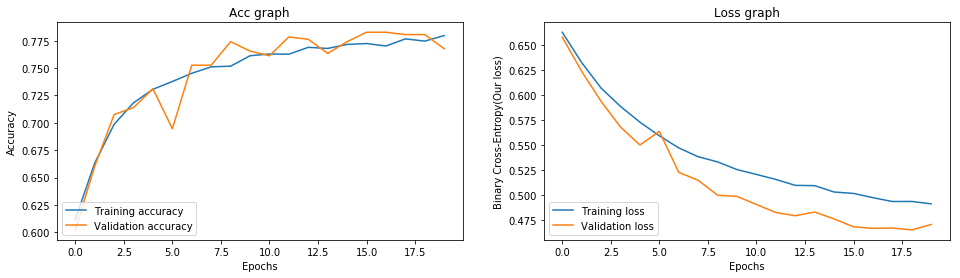

In [0]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history.history['acc']
valid_acc = history.history['val_acc']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [0]:
# Load the best model
from keras.models import load_model
VGG16_model = load_model('best_model_freezed.h5')

### To do: Fine tune the model further by unfreezing some layers and re-fitting the model.

<i>Manual Testing</i>

In [0]:
manual_test = next(validGen)

In [0]:
manual_test_img = manual_test[0]
manual_test_label = manual_test[1]

VGG16_model.predict(manual_test_img)

In [0]:
manual_test_label

<i>Checks Out!</i>

### Save the model

In [0]:
# Save the model
model_json = VGG16_model.to_json()
with open("VGG16_model_base_architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
VGG16_model.save_weights("VGG16_model_base_weights.h5")
print("Saved model to disk")

# Download the model files
from google.colab import files
files.download('VGG16_model_base_architecture.json')
files.download('VGG16_model_base_weights.h5')
print("Downloaded model locally")

In [0]:
# Get predictions from our model
predictions = VGG16_model.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.70      0.80       317
           1       0.59      0.91      0.71       148

   micro avg       0.77      0.77      0.77       465
   macro avg       0.77      0.81      0.76       465
weighted avg       0.83      0.77      0.78       465



In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(predictions_binary,valid_label_list)

0.5336614356021914

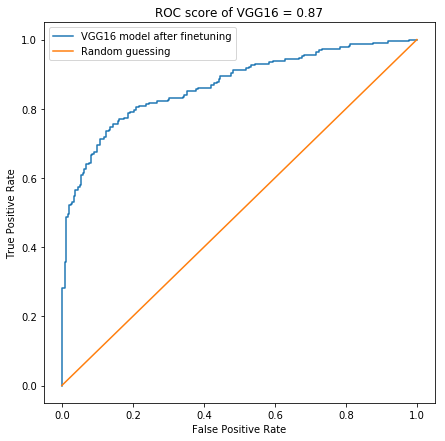

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16 = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## To do further fine-tuing by unfreezing and retraining

In [0]:
# Number of layers in our VGG16 conv base
print('Number of layers =',len(conv_base.layers))

Number of layers = 19


In [0]:
# Try to unfreeze the top 10 layers and train with a smaller learning rate
conv_base.trainable = True

fine_tune_at = 11

for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable = False

In [0]:
# Recompile the model
VGG16_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=2e-5),metrics=['acc'])
VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,846,285
Trainable params: 13,110,791
Non-trainable params: 1,735,494
_________________________________________________________________


In [0]:
# Re-fit the model
# Fit the model using a very small learning rate to avoid ruining nice learnt features due to strong gradients

# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_acc', save_best_only=True)]

# Set the max number of epochs
EPOCHS = 20
history = VGG16_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],workers=0)

Epoch 1/20
494/493 [==============================] - 400s 811ms/step - loss: 0.4930 - acc: 0.7767 - val_loss: 0.4057 - val_acc: 0.8323
Epoch 2/20
494/493 [==============================] - 402s 813ms/step - loss: 0.4210 - acc: 0.8227 - val_loss: 0.3954 - val_acc: 0.8301
Epoch 3/20
494/493 [==============================] - 399s 808ms/step - loss: 0.3860 - acc: 0.8320 - val_loss: 0.3933 - val_acc: 0.8086
Epoch 4/20
494/493 [==============================] - 400s 810ms/step - loss: 0.3642 - acc: 0.8462 - val_loss: 0.3746 - val_acc: 0.8409
Epoch 5/20
494/493 [==============================] - 400s 809ms/step - loss: 0.3342 - acc: 0.8644 - val_loss: 0.3867 - val_acc: 0.8344
Epoch 6/20
494/493 [==============================] - 400s 809ms/step - loss: 0.3054 - acc: 0.8759 - val_loss: 0.4064 - val_acc: 0.8129
Epoch 7/20
494/493 [==============================] - 399s 809ms/step - loss: 0.2835 - acc: 0.8842 - val_loss: 0.4539 - val_acc: 0.8237
Epoch 8/20
494/493 [============================

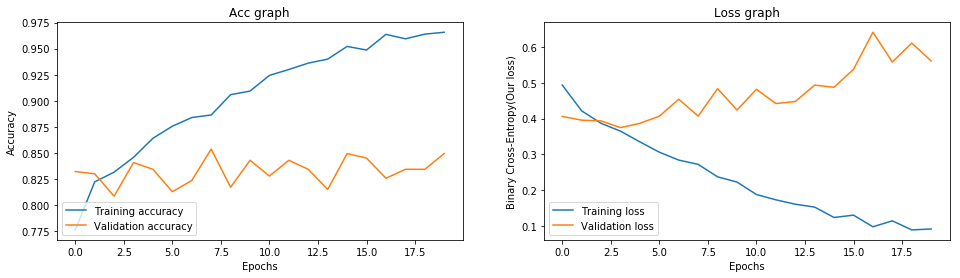

In [0]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history.history['acc']
valid_acc = history.history['val_acc']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [0]:
# Load the best model
from keras.models import load_model
VGG16_model = load_model('best_model_unfreezed.h5')

In [0]:
# Save the model
model_json = VGG16_model.to_json()
with open("VGG16_model_finetuned_architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
VGG16_model.save_weights("VGG16_model_finetuned_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = VGG16_model.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.5608825777126576
Evaluation accuracy = 84.9462361745937


<i>Save model to google drive</i>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
VGG16_model.save('VGG16_finetuned.h5')    
model_file = drive.CreateFile({'title' : 'VGG16_finetuned.h5'})
model_file.SetContentFile('VGG16_finetuned.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1aQiuYR7H-EhYyuD3znlihxHL0upAR6p_'})

#### Get predictions for further metrics

In [0]:
# Get predictions from our model
predictions = VGG16_model.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       247
           1       0.82      0.87      0.84       218

   micro avg       0.85      0.85      0.85       465
   macro avg       0.85      0.85      0.85       465
weighted avg       0.85      0.85      0.85       465



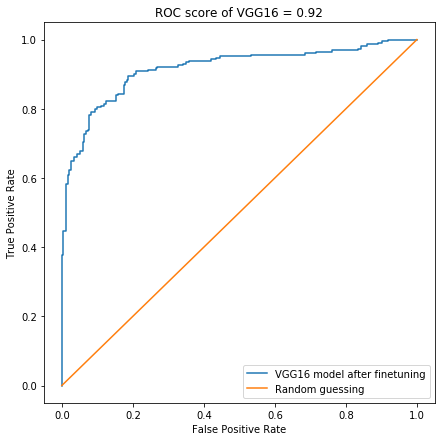

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16 = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## Add some dropout and try to further fit the model

In [0]:
# Add dropout between the flatten - fc1 and fc1 - fc2 layers
# https://stackoverflow.com/questions/42475381/add-dropout-layers-between-pretrained-dense-layers-in-keras
from keras.layers import Dropout
from keras.models import Model

#VGG16_best.layers[:-2]

# Define the dropout layers
dropout1 = Dropout(rate=0.1)
dropout2 = Dropout(rate=0.1)

# Store the previous layers
till_pooling = VGG16_model.layers[-3]
second_last_dense_layer = VGG16_model.layers[-2]
last_dense_layer = VGG16_model.layers[-1]

# Reconnect the layers
x = dropout1(till_pooling.output)
x = second_last_dense_layer(x)
x = dropout2(x)
predictors = last_dense_layer(x)

# Create a new model
VGG16_model_dropout = Model(input=VGG16_model.input, output=predictors)

# Compile the model
VGG16_model_dropout.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-6),metrics=['acc'])

VGG16_model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2_input  (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("de...)`


### After adding the dropout try fitting again to get the best model

In [0]:
# Re-fit the model after adding dropout
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_dropout.h5', monitor='val_loss', save_best_only=True)]

EPOCHS = 50
history_new = VGG16_model_dropout.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/50
494/493 [==============================] - 396s 802ms/step - loss: 0.0595 - acc: 0.9816 - val_loss: 0.5807 - val_acc: 0.8602
Epoch 2/50
494/493 [==============================] - 397s 803ms/step - loss: 0.0469 - acc: 0.9846 - val_loss: 0.5778 - val_acc: 0.8645
Epoch 3/50
494/493 [==============================] - 396s 802ms/step - loss: 0.0389 - acc: 0.9872 - val_loss: 0.5975 - val_acc: 0.8624
Epoch 4/50
494/493 [==============================] - 396s 802ms/step - loss: 0.0357 - acc: 0.9897 - val_loss: 0.5957 - val_acc: 0.8624


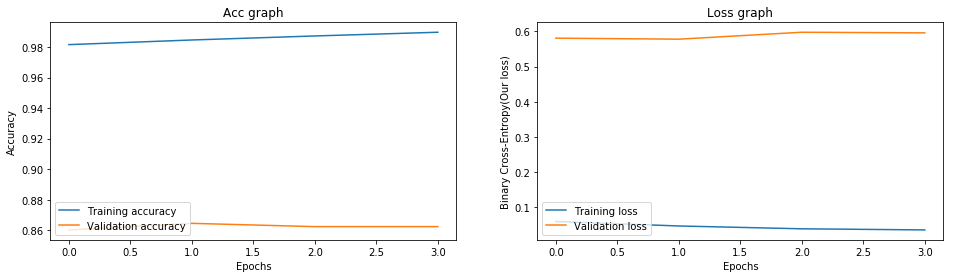

In [0]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history_new.history['acc']
valid_acc = history_new.history['val_acc']
train_loss = history_new.history['loss']
valid_loss = history_new.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [0]:
# Load our best model as VGG16
from keras.models import load_model

VGG16_best_dropout = load_model('best_model_dropout.h5')

In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = VGG16_best_dropout.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.5778068326168283
Evaluation accuracy = 86.45161223667924


In [0]:
# Save the model
model_json = VGG16_model.to_json()
with open("VGG16_model_finetuned_new_architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
VGG16_model.save_weights("VGG16_model_finetuned_new_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# Dwonload this saved model
from google.colab import files
files.download('vgg16_elbow_finetuned_dropout_30epochs.h5')

In [0]:
# Get predictions from our model
predictions = VGG16_best_dropout.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       252
           1       0.83      0.89      0.86       213

   micro avg       0.86      0.86      0.86       465
   macro avg       0.86      0.87      0.86       465
weighted avg       0.87      0.86      0.86       465



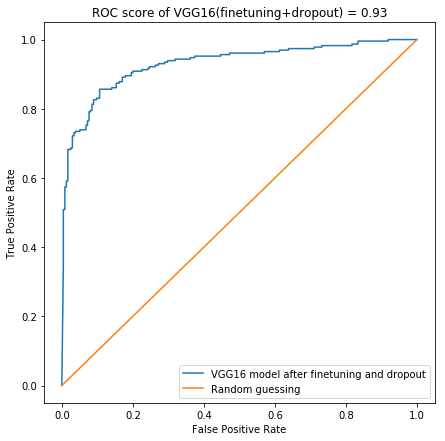

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## We can see that the model is overfitting, therefore increase dropout.

In [0]:
VGG16_best_dropout.layers

In [0]:
VGG16_best_dropout.layers[-3]

In [0]:
# Add dropout between the flatten - fc1 and fc1 - fc2 layers
# https://stackoverflow.com/questions/42475381/add-dropout-layers-between-pretrained-dense-layers-in-keras
from keras.layers import Dropout
from keras.models import Model

#VGG16_best.layers[:-2]

# Define the dropout layers
dropout1 = Dropout(rate=0.3)
dropout2 = Dropout(rate=0.3)

# Store the previous layers
till_pooling = VGG16_best_dropout.layers[-5]
second_last_dense_layer = VGG16_best_dropout.layers[-3]
last_dense_layer = VGG16_best_dropout.layers[-1]

# Reconnect the layers
x = dropout1(till_pooling.output)
x = second_last_dense_layer(x)
x = dropout2(x)
predictors = last_dense_layer(x)

# Create a new model
VGG16_extra_dropout = Model(input=VGG16_best_dropout.input, output=predictors)

# Compile the model
VGG16_extra_dropout.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-6),metrics=['acc'])

VGG16_extra_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2_input  (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("de...)`


In [0]:
# Re-fit the model after adding dropout
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_extra_dropout.h5', monitor='val_loss', save_best_only=True)]

EPOCHS = 50
history_new = VGG16_extra_dropout.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/50
494/493 [==============================] - 395s 800ms/step - loss: 0.0565 - acc: 0.9828 - val_loss: 0.5994 - val_acc: 0.8688
Epoch 2/50
494/493 [==============================] - 396s 801ms/step - loss: 0.0565 - acc: 0.9806 - val_loss: 0.6052 - val_acc: 0.8667
Epoch 3/50
494/493 [==============================] - 396s 801ms/step - loss: 0.0487 - acc: 0.9854 - val_loss: 0.6153 - val_acc: 0.8624


In [0]:
VGG16_extra_dropout = load_model('best_extra_dropout.h5')

In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = VGG16_extra_dropout.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.5993572986667215
Evaluation accuracy = 86.88171973792456


In [0]:
# Save the model
model_json = VGG16_model.to_json()
with open("VGG16_model_finetuned_extra_architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
VGG16_model.save_weights("VGG16_model_extra_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# Get predictions from our model
predictions = VGG16_extra_dropout.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.85      0.87       252
           1       0.83      0.90      0.86       213

   micro avg       0.87      0.87      0.87       465
   macro avg       0.87      0.87      0.87       465
weighted avg       0.87      0.87      0.87       465



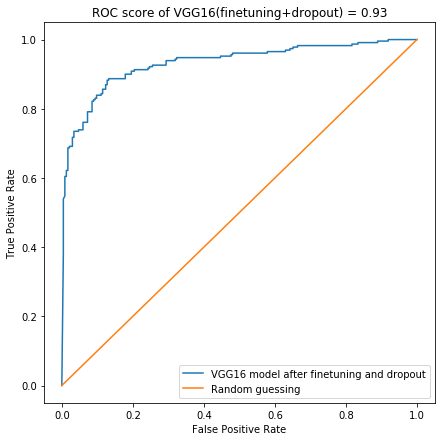

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [0]:
# Add dropout between the flatten - fc1 and fc1 - fc2 layers
# https://stackoverflow.com/questions/42475381/add-dropout-layers-between-pretrained-dense-layers-in-keras
from keras.layers import Dropout
from keras.models import Model

#VGG16_best.layers[:-2]

# Define the dropout layers
dropout1 = Dropout(rate=0.4)
dropout2 = Dropout(rate=0.4)

# Store the previous layers
till_pooling = VGG16_extra_dropout.layers[-5]
second_last_dense_layer = VGG16_extra_dropout.layers[-3]
last_dense_layer = VGG16_extra_dropout.layers[-1]

# Reconnect the layers
x = dropout1(till_pooling.output)
x = second_last_dense_layer(x)
x = dropout2(x)
predictors = last_dense_layer(x)

# Create a new model
VGG16_extra_2_dropout = Model(input=VGG16_extra_dropout.input, output=predictors)

# Compile the model
VGG16_extra_2_dropout.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-7),metrics=['acc'])

VGG16_extra_2_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2_input  (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("de...)`


In [0]:
# Re-fit the model after adding dropout
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_extra_2_dropout.h5', monitor='val_loss', save_best_only=True)]

EPOCHS = 50
history_new = VGG16_extra_2_dropout.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/50
494/493 [==============================] - 398s 805ms/step - loss: 0.0485 - acc: 0.9842 - val_loss: 0.6492 - val_acc: 0.8645
Epoch 2/50
494/493 [==============================] - 396s 801ms/step - loss: 0.0513 - acc: 0.9830 - val_loss: 0.6589 - val_acc: 0.8581
Epoch 3/50
494/493 [==============================] - 397s 803ms/step - loss: 0.0512 - acc: 0.9824 - val_loss: 0.6499 - val_acc: 0.8602


In [0]:
#Try loading our models
from keras.models import model_from_json
from keras import optimizers

# load json and create model
json_file = open('VGG16_model_finetuned_extra_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("VGG16_model_extra_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-7),metrics=['acc'])

Loaded model from disk


In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = loaded_model.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.5957327469011708
Evaluation accuracy = 86.23655842196557


## Loaded our best model successfully

## Now get studywise predictions

Each study can have 1 or more images, To get studywise predictions we predict the class(0/1) of each image of the study and then the final study predcition is the arithmetic mean of the the predictions(sigmoid) of the study images using a threshold value of 0.5 to determine whether the study is classified as 0(normal) or 1(abnormal).

In [0]:
# Studywise predictions
valid_labelled_studies.head(5)

study_name  label  \
866  MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...      1   
867  MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...      1   
868  MURA-v1.1/valid/XR_ELBOW/patient11803/study1_p...      1   
869  MURA-v1.1/valid/XR_ELBOW/patient11804/study1_p...      1   
870  MURA-v1.1/valid/XR_ELBOW/patient11805/study1_p...      1   

                                                images  
866  [MURA-v1.1/valid/XR_ELBOW/patient11659/study1_...  
867  [MURA-v1.1/valid/XR_ELBOW/patient11802/study1_...  
868  [MURA-v1.1/valid/XR_ELBOW/patient11803/study1_...  
869  [MURA-v1.1/valid/XR_ELBOW/patient11804/study1_...  
870  [MURA-v1.1/valid/XR_ELBOW/patient11805/study1_...

In [0]:
# Studywise predictions
studywise_predictions = []
studywise_predictions_binary = []

test_counter = 0

for indx,study_row in valid_labelled_studies.iterrows():
  print('Study:\n',study_row['study_name'])
  
  # List of images for the study
  study_image_list = study_row['images']
  
  # List to store the predictions for each image
  study_predictions = []
  
  # Number of study images
  num_study_imgs = len(study_image_list)
  
  for study_image in study_image_list:
    # Read the image from disk
    image_string = tf.read_file(study_image)
    # Decode the image
    image = tf.image.decode_png(image_string,channels=CHANNELS)
    # Resize into 512x512 images
    image = tf.image.resize_image_with_crop_or_pad(image,SIZE,SIZE)
    # Plot the image
    image = sess.run(image)
    # plt.imshow(image)
    # plt.title(study_image[-10:])
    # plt.show()
    # Make the predictions
    image = np.reshape(image,newshape=[1,512,512,3])
    pred = loaded_model.predict(image)
    study_predictions.append(pred)
    
  # Take the average of all predictions as the study prediction
  avg_prediction = sum(study_predictions)/num_study_imgs
  
  # Sigmoid values
  studywise_predictions.append(avg_prediction)
    
  # Class predictions 0/1
  if avg_prediction < 0.5:
    studywise_predictions_binary.append(0)
  else:
    studywise_predictions_binary.append(1)
  
#   test_counter+=1
  
#   if test_counter==5:
#     break

Study:
 MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11804/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11805/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11414/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11806/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11807/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11793/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11358/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study2_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11586/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11389/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11808/study1_po

In [0]:
# Get the study classification report
from sklearn.metrics import classification_report
print(classification_report(studywise_predictions_binary,valid_labelled_studies['label'].tolist()),)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       103
           1       0.76      0.91      0.83        55

   micro avg       0.87      0.87      0.87       158
   macro avg       0.85      0.88      0.86       158
weighted avg       0.88      0.87      0.87       158



In [0]:
# Getting the sigmoid values in proper format
stdy_predictions = []

for i in range(len(studywise_predictions)):
  stdy_predictions.append(studywise_predictions[i][0][0])

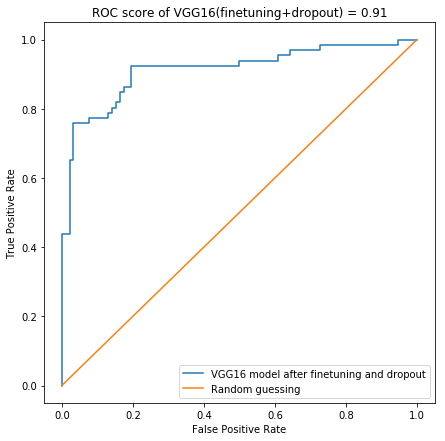

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_labelled_studies['label'].tolist(),stdy_predictions)
auc_score = roc_auc_score(valid_labelled_studies['label'].tolist(),stdy_predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(studywise_predictions_binary,valid_labelled_studies['label'].tolist())

0.7201889020070837